# 搭建一个简单的 CNN 实现 MNIST分类
前面我们已经使用 tensorflow 实现了全链接网络进行 MNIST 手写字符的分类。现在我们要搭建一个简单的卷积神经网络来进行分类，在学习本教程之前，你应该掌握 CNN 的原理，如果你还没有理解的话，建议先学习一下： [CS231n: Convolutional Neural Networks (CNNs / ConvNets)](http://cs231n.github.io/convolutional-networks/)

需要注意的一点是 padding 的方式，在 padding 中有 "valid" 和 "same" 两种方式，可以参考[tensorflow conv2d的padding解释以及参数解释](https://blog.csdn.net/lujiandong1/article/details/53728053)：
- valid: 在滑动窗口的时候，如果最后剩下的部分不够窗口大小了，直接丢弃最后的部分。
- same: 在图片周围填充 0，填充方式如下。

![padding意图](https://img-blog.csdn.net/20161218155916268?watermark/2/text/aHR0cDovL2Jsb2cuY3Nkbi5uZXQvbHVqaWFuZG9uZzE=/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70/gravity/Center)
图片来自：https://blog.csdn.net/lujiandong1/article/details/53728053

关于 "same" 方式的padding计算，可以参考官方文档：https://www.tensorflow.org/api_guides/python/nn#convolution

计算如下，取一个维度进行分析，比如取高度 n 

$$n_o = \left \lceil{\frac{n_i}{s}}\right \rceil$$

其中，$n_i$ 表示输入的高度，$s$ 表示滑动步长 stride， $n_o$ 表示输出的高度。可以看到，**使用 `same` 方式，输出维度和窗口大小是没有关系的。**

那么，需要 padding 的个数为 :
$$n_{padding} = (n_o- 1)*s + f - n_i$$

其中， $f$ 为卷积核的高度。

得到需要 padding 的数量以后，一般都是在两端均匀padding，那么在上方 padding 的数量为：
$$n_{toppad} = \lfloor{n_{padding}/2}\rfloor$$

则在下方padding的数量为：
$$n_{uppad} = n_{padding} - n_{toppad}$$

为了初学者能够更好地理解，下面都采用最暴力的方式来写。实际上卷积层，全链接层之类的，我们都会定义一个函数来实现。在下一个例子中，我们再写一个优雅一点的 CNN 网络。

In [1]:
import warnings
warnings.filterwarnings('ignore')  # 不打印 warning 

import tensorflow as tf

# 设置GPU按需增长
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

import numpy as np

## 1.导入数据，用 tensorflow 导入

In [2]:
# 用tensorflow 导入数据
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../data/MNIST_data', one_hot=True) 
# 看看咱们样本的数量
print(mnist.test.labels.shape)
print(mnist.train.labels.shape)

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../data/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../data/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
(10000, 10)
(55000, 10)


## 2. 构建网络

In [3]:
def weight_variable(shape):
    # 用正态分布来初始化权值
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    # 本例中用relu激活函数，所以用一个很小的正偏置较好
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# 定义卷积层
def conv2d(x, W):
    # 默认 strides[0]=strides[3]=1, strides[1]为x方向步长，strides[2]为y方向步长
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

# pooling 层
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')


X_input = tf.placeholder(tf.float32, [None, 784])
y_input = tf.placeholder(tf.float32, [None, 10])

# 把X转为卷积所需要的形式
X = tf.reshape(X_input, [-1, 28, 28, 1])
# 第一层卷积：5×5×1卷积核32个 [5，5，1，32]
W_conv1 = weight_variable([5,5,1,32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(X, W_conv1) + b_conv1)

# 第一个pooling 层
h_pool1 = max_pool_2x2(h_conv1)

# 第二层卷积：5×5×32卷积核64个 [5，5，32，64]
W_conv2 = weight_variable([5,5,32,64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

# 第二个pooling 层,输出[None, 7, 7, 64] ? 
h_pool2 = max_pool_2x2(h_conv2)

# flatten
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])

# fc1
W_fc1 = weight_variable([7*7*64, 1024])
b_fc1 = bias_variable([1024])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# dropout: 输出的维度和h_fc1一样，只是随机部分值被值为零
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# 输出层
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_pred = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

看看各层输出 tensor 的维度，在 notebook 中，最方便的就是你可以经常打印变量的状态来看看是不是和你想的是一致的。

In [4]:
print('X_input:', X_input)
print('X:      ', X)
print('y_input:', y_input)
print('h_conv1:', h_conv1)
print('h_pool1:', h_pool1)
print('h_conv2:', h_conv2)
print('h_pool2:', h_pool2)
print('h_fc1:  ', h_fc1)
print('y_pred: ', y_pred)

X_input: Tensor("Placeholder:0", shape=(?, 784), dtype=float32)
X:       Tensor("Reshape:0", shape=(?, 28, 28, 1), dtype=float32)
y_input: Tensor("Placeholder_1:0", shape=(?, 10), dtype=float32)
h_conv1: Tensor("Relu:0", shape=(?, 28, 28, 32), dtype=float32)
h_pool1: Tensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
h_conv2: Tensor("Relu_1:0", shape=(?, 14, 14, 64), dtype=float32)
h_pool2: Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)
h_fc1:   Tensor("Relu_2:0", shape=(?, 1024), dtype=float32)
y_pred:  Tensor("Softmax:0", shape=(?, 10), dtype=float32)


## 3.训练和评估

<b> 在测试的时候不使用 mini_batch， 那么测试的时候会占用较多的GPU（8817M），这在 notebook 交互式编程中是不推荐的。

In [7]:
cross_entropy = -tf.reduce_sum(y_input*tf.log(y_pred))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_pred,1), tf.argmax(y_input,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())

for i in range(5000):
    X_batch, y_batch = mnist.train.next_batch(batch_size=100)
    cost, acc,  _ = sess.run([cross_entropy, accuracy, train_step], feed_dict={X_input: X_batch, y_input: y_batch, keep_prob: 0.5})
    if (i+1) % 500 == 0:
        test_cost, test_acc = sess.run([cross_entropy, accuracy], feed_dict={X_input: mnist.test.images, y_input: mnist.test.labels, keep_prob: 1.0})
        print("step {}, train cost={:.6f}, acc={:.6f}; test cost={:.6f}, acc={:.6f}".format(i+1, cost, acc, test_cost, test_acc))

step 500, train cost=32.956459, acc=0.890000; test cost=1617.352783, acc=0.955700
step 1000, train cost=14.774936, acc=0.950000; test cost=1061.980713, acc=0.969400
step 1500, train cost=13.221946, acc=0.950000; test cost=755.346191, acc=0.976700
step 2000, train cost=11.899247, acc=0.960000; test cost=616.950256, acc=0.980600
step 2500, train cost=13.984218, acc=0.980000; test cost=558.348022, acc=0.981400
step 3000, train cost=14.924292, acc=0.970000; test cost=455.922638, acc=0.985600
step 3500, train cost=2.872833, acc=0.980000; test cost=436.595032, acc=0.984600
step 4000, train cost=8.945153, acc=0.980000; test cost=411.047852, acc=0.986000
step 4500, train cost=6.661867, acc=0.980000; test cost=355.093719, acc=0.987400
step 5000, train cost=1.669370, acc=1.000000; test cost=343.728882, acc=0.987600


<b> 下面改成了 test 也用 mini_batch 的形式， 显存只用了 529M,所以还是很成功的。

In [6]:
cross_entropy = -tf.reduce_sum(y_input * tf.log(y_pred))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# 3.预测准确结果统计
correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_input, 1))  
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 定义了变量必须要初始化，或者下面形式
sess.run(tf.global_variables_initializer())

import time


time0 = time.time()
# 训练
for i in range(5000):
    X_batch, y_batch = mnist.train.next_batch(batch_size=100)
    cost, acc,  _ = sess.run([cross_entropy, accuracy, train_step], feed_dict={X_input: X_batch, y_input: y_batch, keep_prob: 0.5})
    if (i+1) % 500 == 0:
        # 分 100 个batch 迭代
        test_acc = 0.0
        test_cost = 0.0
        N = 100
        for j in range(N):
            X_batch, y_batch = mnist.test.next_batch(batch_size=100)
            _cost, _acc = sess.run([cross_entropy, accuracy], feed_dict={X_input: X_batch, y_input: y_batch, keep_prob: 1.0})
            test_acc += _acc
            test_cost += _cost
        print("step {}, train cost={:.6f}, acc={:.6f}; test cost={:.6f}, acc={:.6f}; pass {}s".format(i+1, cost, acc, test_cost/N, test_acc/N, time.time() - time0))
        time0 = time.time()

step 500, train cost=24.613052, acc=0.920000; test cost=15.051726, acc=0.955600; pass 2.5465638637542725s
step 1000, train cost=14.351367, acc=0.960000; test cost=9.154838, acc=0.973900; pass 2.396472930908203s
step 1500, train cost=23.211666, acc=0.950000; test cost=7.125742, acc=0.978200; pass 2.392526149749756s
step 2000, train cost=14.013665, acc=0.950000; test cost=5.870811, acc=0.982000; pass 2.3678934574127197s
step 2500, train cost=3.635154, acc=1.000000; test cost=4.959528, acc=0.984300; pass 2.4310600757598877s
step 3000, train cost=4.492582, acc=0.980000; test cost=3.975064, acc=0.986300; pass 2.397819757461548s
step 3500, train cost=1.197423, acc=1.000000; test cost=3.901103, acc=0.986800; pass 2.602867364883423s
step 4000, train cost=13.277801, acc=0.950000; test cost=3.582187, acc=0.988500; pass 2.360400915145874s
step 4500, train cost=5.978199, acc=0.980000; test cost=3.084232, acc=0.989600; pass 2.3935186862945557s
step 5000, train cost=1.932325, acc=0.990000; test cost

## 4. 查看网络中间结果

<b> 在学习 CNN 的过程中，老是看到他们用图片的形式展示了中间层卷积的输出。好吧，这下我必须得自己实现以下看看呀！！！</b>
<br/> 关于 python 图片操作主要有 matplotlib 和 PIL 两个库（refer to: http://www.cnblogs.com/yinxiangnan-charles/p/5928689.html）。
<br/>我们使用 matplotlib 来完成这个任务。

### 4.1 图像操作基础

In [12]:
# 我们先来看看数据是什么样的
img1 = mnist.train.images[0]
label1 = mnist.train.labels[0]
print(label1)
print('img_data shape =', img1.shape)  # 我们需要把它转为 28 * 28 的矩阵
img1 = img1.reshape([28, 28])

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
img_data shape = (784,)


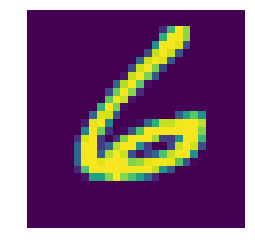

In [13]:
import matplotlib.pyplot as plt
# import matplotlib.image as mpimg  # 用于读取图片，这里用不上

plt.imshow(img1)
plt.axis('off') # 不显示坐标轴
plt.show()   

好吧，是显示了图片，但是结果是热度图像。我们想显示的是灰度图像。

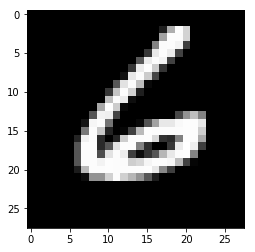

In [14]:
# 我们可以通过设置 cmap 参数来显示灰度图
plt.imshow(img1, cmap='gray') # 'hot' 是热度图
plt.show()

### 4.2 显示网络中间结果

好了，有了前面的图像操作基础，我们就该试试吧！！！

In [16]:
# 首先应该把 img1 转为正确的shape (None, 784)
X_img = img1.reshape([-1, 784])
y_img = mnist.train.labels[1].reshape([-1, 10])
# 我们要看 Conv1 的结果，即 h_conv1
result = sess.run([h_conv1], feed_dict={X_input: X_img, keep_prob:1.0})[0]
print(result.shape)
print(type(result))

(1, 28, 28, 32)
<class 'numpy.ndarray'>


好的，我们成功的计算得到了 h_conv1，那么赶紧 imshow() 看看吧！！！

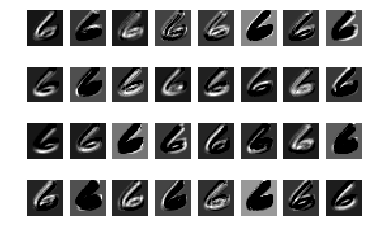

In [19]:
for i in range(32):
    show_img = result[:,:,:,i]
    show_img = show_img.reshape([28, 28])
    plt.subplot(4, 8, i + 1)
    plt.imshow(show_img, cmap='gray')
    plt.axis('off')
plt.show()

哈哈，成功啦！从上面的结果中，我们可以看到不同的滤波器（卷积核）学习到了不同的特征。比如有的滤波器学习到了边缘信息，有的则学习到了骨干的信息。感觉好有趣，不由自主的想对另一个数字看看。

In [22]:
print(mnist.train.labels[:10])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


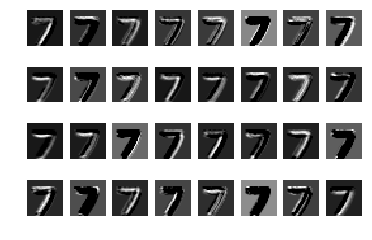

In [23]:
# 首先应该把 img1 转为正确的shape (None, 784)
X_img = mnist.train.images[5].reshape([-1, 784])
result = sess.run([h_conv1], feed_dict={X_input: X_img, keep_prob:1.0})[0]

for i in range(32):
    show_img = result[:,:,:,i]
    show_img = show_img.reshape([28, 28])
    plt.subplot(4, 8, i + 1)
    plt.imshow(show_img, cmap='gray')
    plt.axis('off')
plt.show()

## 总结
这个教程我们搭建了一个非常简单的CNN进行 MNIST 手写数字的识别。上面的各个层都是一行一行的非常“脚本”式的写法，在初学者来说，一行一行地运行能够更好地理解每行代码的意思。

实际上，就一个简单的图像分类任务，其网络结构可能非常复杂。比如 AlexNet 就有好几个 conv layer/ pooling layer/ fully connected layer 等等，更别说 GoogLeNet 和 ResNet。对于这些庞大的网络，我们不可能再一行一行地去写，而是要把 conv layer/ pooling layer/ fully connected layer / BN layer 分别封装成函数。同时，要好好地利用前面我们学到的 tf.variable_scope() 和 tf.get_variable() 来优雅地定义网络结构。

此外，网络的初始化也会影响网络的性能，还有在模型训练的过程中，怎么组织数据的输入，怎么选择 batch_size 等都是我们要考虑的。而这些内容需要自己解决具体的问题慢慢总结出来。